In [1]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install fitter

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
air_quality = fetch_ucirepo(id=360) 
  
# data (as pandas dataframes) 
X = air_quality.data.features 
y = air_quality.data.targets 
  
# metadata 
print(air_quality.metadata) 
  
# variable information 
print(air_quality.variables) 


{'uci_id': 360, 'name': 'Air Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/360/air+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/360/data.csv', 'abstract': 'Contains the responses of a gas multisensor device deployed on the field in an Italian city. Hourly responses averages are recorded along with gas concentrations references from a certified analyzer. ', 'area': 'Computer Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 9358, 'num_features': 15, 'feature_types': ['Real'], 'demographics': [], 'target_col': None, 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2008, 'last_updated': 'Sun Mar 10 2024', 'dataset_doi': '10.24432/C59K5F', 'creators': ['Saverio Vito'], 'intro_paper': {'title': 'On field calibration of an electronic nose for benzene estimation in an urban pollution monitoring scenario', 'authors': 'S. D. Vito, E. Massera, M. P

In [4]:
import numpy as np
import pandas as pd
from fitter import Fitter, get_common_distributions, get_distributions
X

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,3/10/2004,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,3/10/2004,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,3/10/2004,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,3/10/2004,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,3/10/2004,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,4/4/2005,10:00:00,3.1,1314,-200,13.5,1101,472,539,190,1374,1729,21.9,29.3,0.7568
9353,4/4/2005,11:00:00,2.4,1163,-200,11.4,1027,353,604,179,1264,1269,24.3,23.7,0.7119
9354,4/4/2005,12:00:00,2.4,1142,-200,12.4,1063,293,603,175,1241,1092,26.9,18.3,0.6406
9355,4/4/2005,13:00:00,2.1,1003,-200,9.5,961,235,702,156,1041,770,28.3,13.5,0.5139


In [5]:
Y=X['NOx(GT)']

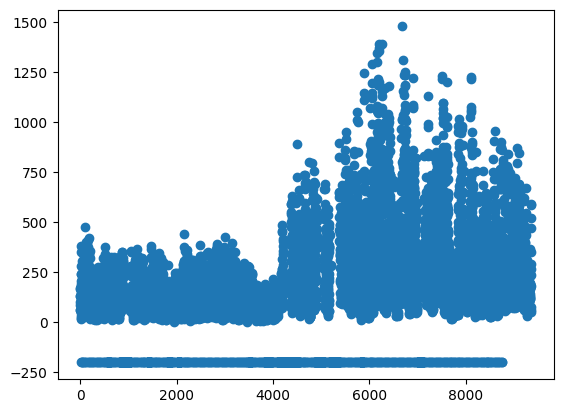

In [6]:
import matplotlib.pyplot as plt
plt.scatter(x=range(0, len(Y)), y=Y)

In [7]:
temp = X['Date']+' '+X['Time']
X['temp']=temp

In [8]:
import plotly.express as px

fig = px.scatter(X,x="temp",y='NOx(GT)')
fig.show()

In [9]:
Y_index = Y<0

In [10]:
sum(Y_index)

1639

In [11]:
fig2=px.box(y=Y)
fig2.show()

In [12]:
X_noxt=np.array(X['NOx(GT)'])

In [13]:
q3=np.quantile(X_noxt, 0.75)
q1=np.quantile(X_noxt, 0.25)
limsp=q3+1.5*(q3-q1)
liminf=q1-1.5*(q3-q1)

In [14]:
pos_atipicos=[]
for i in range(0, len(X_noxt)):
    if X_noxt[i]>limsp:
        pos_atipicos.append(i)
pos_atipicos
    

[4490,
 4491,
 4549,
 4647,
 4657,
 4669,
 4670,
 4671,
 4695,
 4742,
 4743,
 4813,
 4839,
 4840,
 4848,
 4849,
 4863,
 5066,
 5077,
 5080,
 5374,
 5375,
 5376,
 5377,
 5424,
 5486,
 5494,
 5495,
 5496,
 5497,
 5498,
 5517,
 5518,
 5519,
 5520,
 5521,
 5557,
 5558,
 5559,
 5560,
 5566,
 5567,
 5568,
 5588,
 5681,
 5682,
 5684,
 5685,
 5687,
 5688,
 5689,
 5690,
 5691,
 5728,
 5735,
 5736,
 5751,
 5752,
 5753,
 5759,
 5760,
 5832,
 5894,
 5895,
 5896,
 5897,
 5898,
 5900,
 5901,
 5907,
 6014,
 6015,
 6016,
 6017,
 6024,
 6038,
 6042,
 6043,
 6044,
 6045,
 6046,
 6047,
 6048,
 6049,
 6050,
 6051,
 6062,
 6063,
 6064,
 6065,
 6066,
 6095,
 6096,
 6097,
 6098,
 6112,
 6120,
 6158,
 6159,
 6160,
 6161,
 6162,
 6163,
 6164,
 6165,
 6166,
 6167,
 6168,
 6169,
 6170,
 6171,
 6172,
 6182,
 6183,
 6184,
 6185,
 6186,
 6187,
 6188,
 6189,
 6190,
 6191,
 6192,
 6193,
 6194,
 6195,
 6196,
 6197,
 6198,
 6206,
 6207,
 6208,
 6215,
 6216,
 6217,
 6218,
 6219,
 6220,
 6221,
 6222,
 6223,
 6230,
 6231,

In [15]:
X_noxt=X[X['NOx(GT)']<limsp]
X_noxt

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,temp
0,3/10/2004,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578,3/10/2004 18:00:00
1,3/10/2004,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255,3/10/2004 19:00:00
2,3/10/2004,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502,3/10/2004 20:00:00
3,3/10/2004,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867,3/10/2004 21:00:00
4,3/10/2004,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888,3/10/2004 22:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,4/4/2005,10:00:00,3.1,1314,-200,13.5,1101,472,539,190,1374,1729,21.9,29.3,0.7568,4/4/2005 10:00:00
9353,4/4/2005,11:00:00,2.4,1163,-200,11.4,1027,353,604,179,1264,1269,24.3,23.7,0.7119,4/4/2005 11:00:00
9354,4/4/2005,12:00:00,2.4,1142,-200,12.4,1063,293,603,175,1241,1092,26.9,18.3,0.6406,4/4/2005 12:00:00
9355,4/4/2005,13:00:00,2.1,1003,-200,9.5,961,235,702,156,1041,770,28.3,13.5,0.5139,4/4/2005 13:00:00


In [16]:
X_noxt=X[X['NOx(GT)']>liminf]
X_noxt

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,temp
0,3/10/2004,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578,3/10/2004 18:00:00
1,3/10/2004,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255,3/10/2004 19:00:00
2,3/10/2004,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502,3/10/2004 20:00:00
3,3/10/2004,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867,3/10/2004 21:00:00
4,3/10/2004,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888,3/10/2004 22:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,4/4/2005,10:00:00,3.1,1314,-200,13.5,1101,472,539,190,1374,1729,21.9,29.3,0.7568,4/4/2005 10:00:00
9353,4/4/2005,11:00:00,2.4,1163,-200,11.4,1027,353,604,179,1264,1269,24.3,23.7,0.7119,4/4/2005 11:00:00
9354,4/4/2005,12:00:00,2.4,1142,-200,12.4,1063,293,603,175,1241,1092,26.9,18.3,0.6406,4/4/2005 12:00:00
9355,4/4/2005,13:00:00,2.1,1003,-200,9.5,961,235,702,156,1041,770,28.3,13.5,0.5139,4/4/2005 13:00:00


In [17]:
fig3 = px.box(y=X_noxt['PT08.S1(CO)'])
fig3.show()

In [18]:
total_atipicos=[]
for column in X:
    if column == "Time" or column == "Date" or column == "temp":
        continue

    x_temp = X[column]
    q3=np.quantile(x_temp, 0.75)
    q1=np.quantile(x_temp, 0.25)
    limsp=q3+1.5*(q3-q1)
    liminf=q1-1.5*(q3-q1)
    for i in range(0, len(x_temp)):
        if x_temp[i]>limsp:
            if i not in total_atipicos:
                total_atipicos.append(i)
        if x_temp[i]<liminf:
            if i not in total_atipicos:
                total_atipicos.append(i)    

In [20]:
len(total_atipicos)

3895

In [24]:
X_new = X.drop(total_atipicos)
X_new = X_new.reset_index()

In [25]:
X_new

,index,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,temp
0,184,3/18/2004,10:00:00,4.5,1617,-200,21.3,1333,349,686,150,2010,1819,17.8,40.5,0.8210,3/18/2004 10:00:00
1,185,3/18/2004,11:00:00,2.8,1473,-200,14.3,1127,224,831,152,1752,1568,20.8,34.4,0.8365,3/18/2004 11:00:00
2,186,3/18/2004,12:00:00,2.2,1379,-200,12.5,1068,171,899,139,1663,1374,23.8,28.2,0.8219,3/18/2004 12:00:00
3,187,3/18/2004,13:00:00,2.2,1385,-200,12.2,1056,149,891,133,1648,1268,24.2,28.7,0.8515,3/18/2004 13:00:00
4,188,3/18/2004,14:00:00,2.3,1379,-200,13.1,1087,137,901,126,1660,1144,25.2,24.9,0.7829,3/18/2004 14:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5457,9352,4/4/2005,10:00:00,3.1,1314,-200,13.5,1101,472,539,190,1374,1729,21.9,29.3,0.7568,4/4/2005 10:00:00
5458,9353,4/4/2005,11:00:00,2.4,1163,-200,11.4,1027,353,604,179,1264,1269,24.3,23.7,0.7119,4/4/2005 11:00:00
5459,9354,4/4/2005,12:00:00,2.4,1142,-200,12.4,1063,293,603,175,1241,1092,26.9,18.3,0.6406,4/4/2005 12:00:00
5460,9355,4/4/2005,13:00:00,2.1,1003,-200,9.5,961,235,702,156,1041,770,28.3,13.5,0.5139,4/4/2005 13:00:00


In [37]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

regr = linear_model.LinearRegression()
input=X_new[['PT08.S1(CO)', 'PT08.S2(NMHC)']]
regr.fit(input, X_new['CO(GT)'])

LinearRegression()

In [38]:
Y_predict=(regr.predict(input))

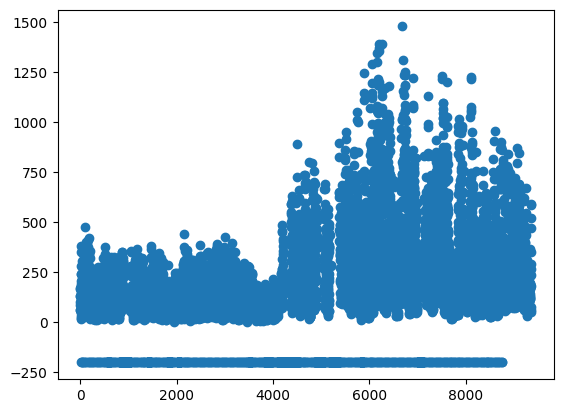

In [39]:
plt.scatter(x=range(len(X_noxt['NOx(GT)'])),y=X_noxt['NOx(GT)'])

In [40]:
X_new['predict']=Y_predict

In [41]:
fig4 = px.scatter(X_new, x='temp', y='predict')
fig4.show()

In [42]:
fig5 = px.scatter(X_new, x='temp', y='NOx(GT)')
fig5.show()

In [43]:
mean_squared_error(X_new['CO(GT)'], X_new['predict'])

0.21405239596817338

In [44]:
r2_score(X_new['CO(GT)'], X_new['predict'])

0.8125493144218575

Punto #1 encontrar un mejor modelo de regresión con CO(GT) con un máximo de 5 columnas.
Punto #2 encontrar de C6H6 con un modelo de regresión >0.7 en R2 con máximo de 5 columnas.